<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perfil de emissões do matopiba

In [8]:
#analisis
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy import stats

import matplotlib.gridspec as gridspec

#visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pandas.plotting import radviz

In [2]:
! git clone https://github.com/lucas-fpaiva/matopiba_emissions.git

Cloning into 'matopiba_emissions'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 45 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


# Limpeza e transformção dos dados 

In [4]:
df = pd.read_csv('/content/matopiba_emissions/data/data.csv',
              error_bad_lines=False, encoding='latin-1',sep=';')#

df['emi_energy_2018']=pd.to_numeric(df['emi_energy_2018'],errors='coerce')
df.dropna(inplace=True)
df.columns

data=df[['States', 'Municipalities', 'emi_2018', 'emi_agri_2018', 
       'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018', 
        'pib_2018']]

data['population'] = 1000*df['pib_2018']/df['pib_percapta_2018']
data['population']= data['population'].astype(int)
df.dropna(inplace=True)
data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(328, 9)

In [11]:
def features_func(data_l):
    
    emi_2018 = ['emi_2018', 'emi_agri_2018', 'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018']
    
    
    j=0
    for i in emi_2018[1:]:
        data_l[features[j]] = data_l[i]/data_l[emi_2018[0]]
        j+=1

    return data_l

In [79]:
features=["Agriculture and Livestock","LUC","Energy","Waste"]
features_group=["Agriculture and Livestock","LUC","Energy","Waste","group"]
data_proces= features_func(data)
data_proces.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


States           Municipalities    emi_2018  emi_agri_2018  emi_luc_2018  \
0     TO             AbreulÃ¢ndia   415469.12      127828.13        286357   
1     MA             AÃ§ailÃ¢ndia  2012738.16      701929.89       1033654   
2     MA             Afonso Cunha    77780.74        7322.15         59017   
3     MA  Ãgua Doce do MaranhÃ£o    28598.69        6986.73         15176   
4     TO           AguiarnÃ³polis   116760.47       20766.03         31678   

   emi_energy_2018  emi_waste_2018    pib_2018  population  \
0           530.51          753.48    52402.19        2564   
1        221796.36        55357.90  2602790.66      111757   
2         10089.06         1352.53    50235.77        6468   
3          3941.72         2494.25    86186.06       12488   
4         62457.73         1858.71   124903.42        6571   

   Agriculture and Livestock       LUC    Energy     Waste  group group_name  
0                   0.307672  0.689238  0.001277  0.001814      1         G1  
1                   0.348744  0.513556  0.110196  0.027504      1         G1  
2                   0.094138  0.758761  0.129712  0.017389      5         G5  
3                   0.244302  0.530654  0.137829  0.087216      1         G1  
4                   0.177852  0.271308  0.534922  0.015919      2         G2

# Agrupamento

In [54]:
def number_of_clusters(wcss,interval):
    x1, y1 = interval[0], wcss[0]
    x2, y2 = interval[1], wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


def silhouette_plot_(X,range_n,lim):
  nome = list(X.columns)

  kmeans_per_k = [KMeans(k,init = "k-means++", n_init=50, random_state=0).fit(X)
                for k in range(1, lim)]
  inertias = [model.inertia_ for model in kmeans_per_k]

  k_opt = number_of_clusters(inertias,[1,lim])
  print(k_opt)
  fig = plt.figure(figsize = (15, 10), dpi = 300)
  gs = gridspec.GridSpec(11, 3)
  ax = fig.add_subplot(gs[0:4, :])
  ax.plot(range(2,lim+1), inertias, "bo-")
  ks = [k_opt-1,k_opt,k_opt+1]

  # print("k ótimo: ", k_opt)
  ax.plot(ks,inertias[k_opt-3:k_opt],"ro-",linewidth=2, markersize=12)

  ax.set_ylabel("WCSS", fontsize=fontsize)
  ax.set_xlabel("Groups \n", fontsize=fontsize)
  ax.grid(True)
  ax.annotate('Elbow',
             xy=(k_opt, inertias[k_opt]+0.5),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=fontsize,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

  j=0
   
  ax.text(-0.15/3, 1.1, 'a', transform=ax.transAxes, 
            size=22, weight='bold')
    
    
  for n_clusters in range_n:
    
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, init = "k-means++", n_init=50, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    if n_clusters==k_opt:
      global model_top
      global labels 
      labels = cluster_labels
      model_top = clusterer

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    ax = fig.add_subplot(gs[6:11, j])
    ax.grid(True)
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
    
    
    for i in range(n_clusters-1,-1,-1):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them      
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
    
  #   for i in range(1,k+1):
  # color.append(cm.nipy_spectral(float(i-1)*1.1 /k))

      color = cm.nipy_spectral(float(i)*1.1 / n_clusters)
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=1)

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples
      # print(i,len(ith_cluster_silhouette_values))
    
      ax.set_title("k = "+str(n_clusters),fontsize=fontsize)
    if j==1:
      ax.set_xlabel("Silhouette score", fontsize=fontsize)
    if j==0:
        ax.set_ylabel("Groups \n", fontsize=fontsize)
        ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
            size=22, weight='bold')
    j+=1
    # The vertical line for average silhouette score of all the values
    ax.set_xlim([-0.2, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  plt.savefig("/content/matopiba_emissions/output/figure1.pdf", format="pdf", dpi=1000)
  plt.show()
  



6
For n_clusters = 5 The average silhouette_score is : 0.42146118408488387
For n_clusters = 6 The average silhouette_score is : 0.42444966752841917
For n_clusters = 7 The average silhouette_score is : 0.40231761635176794


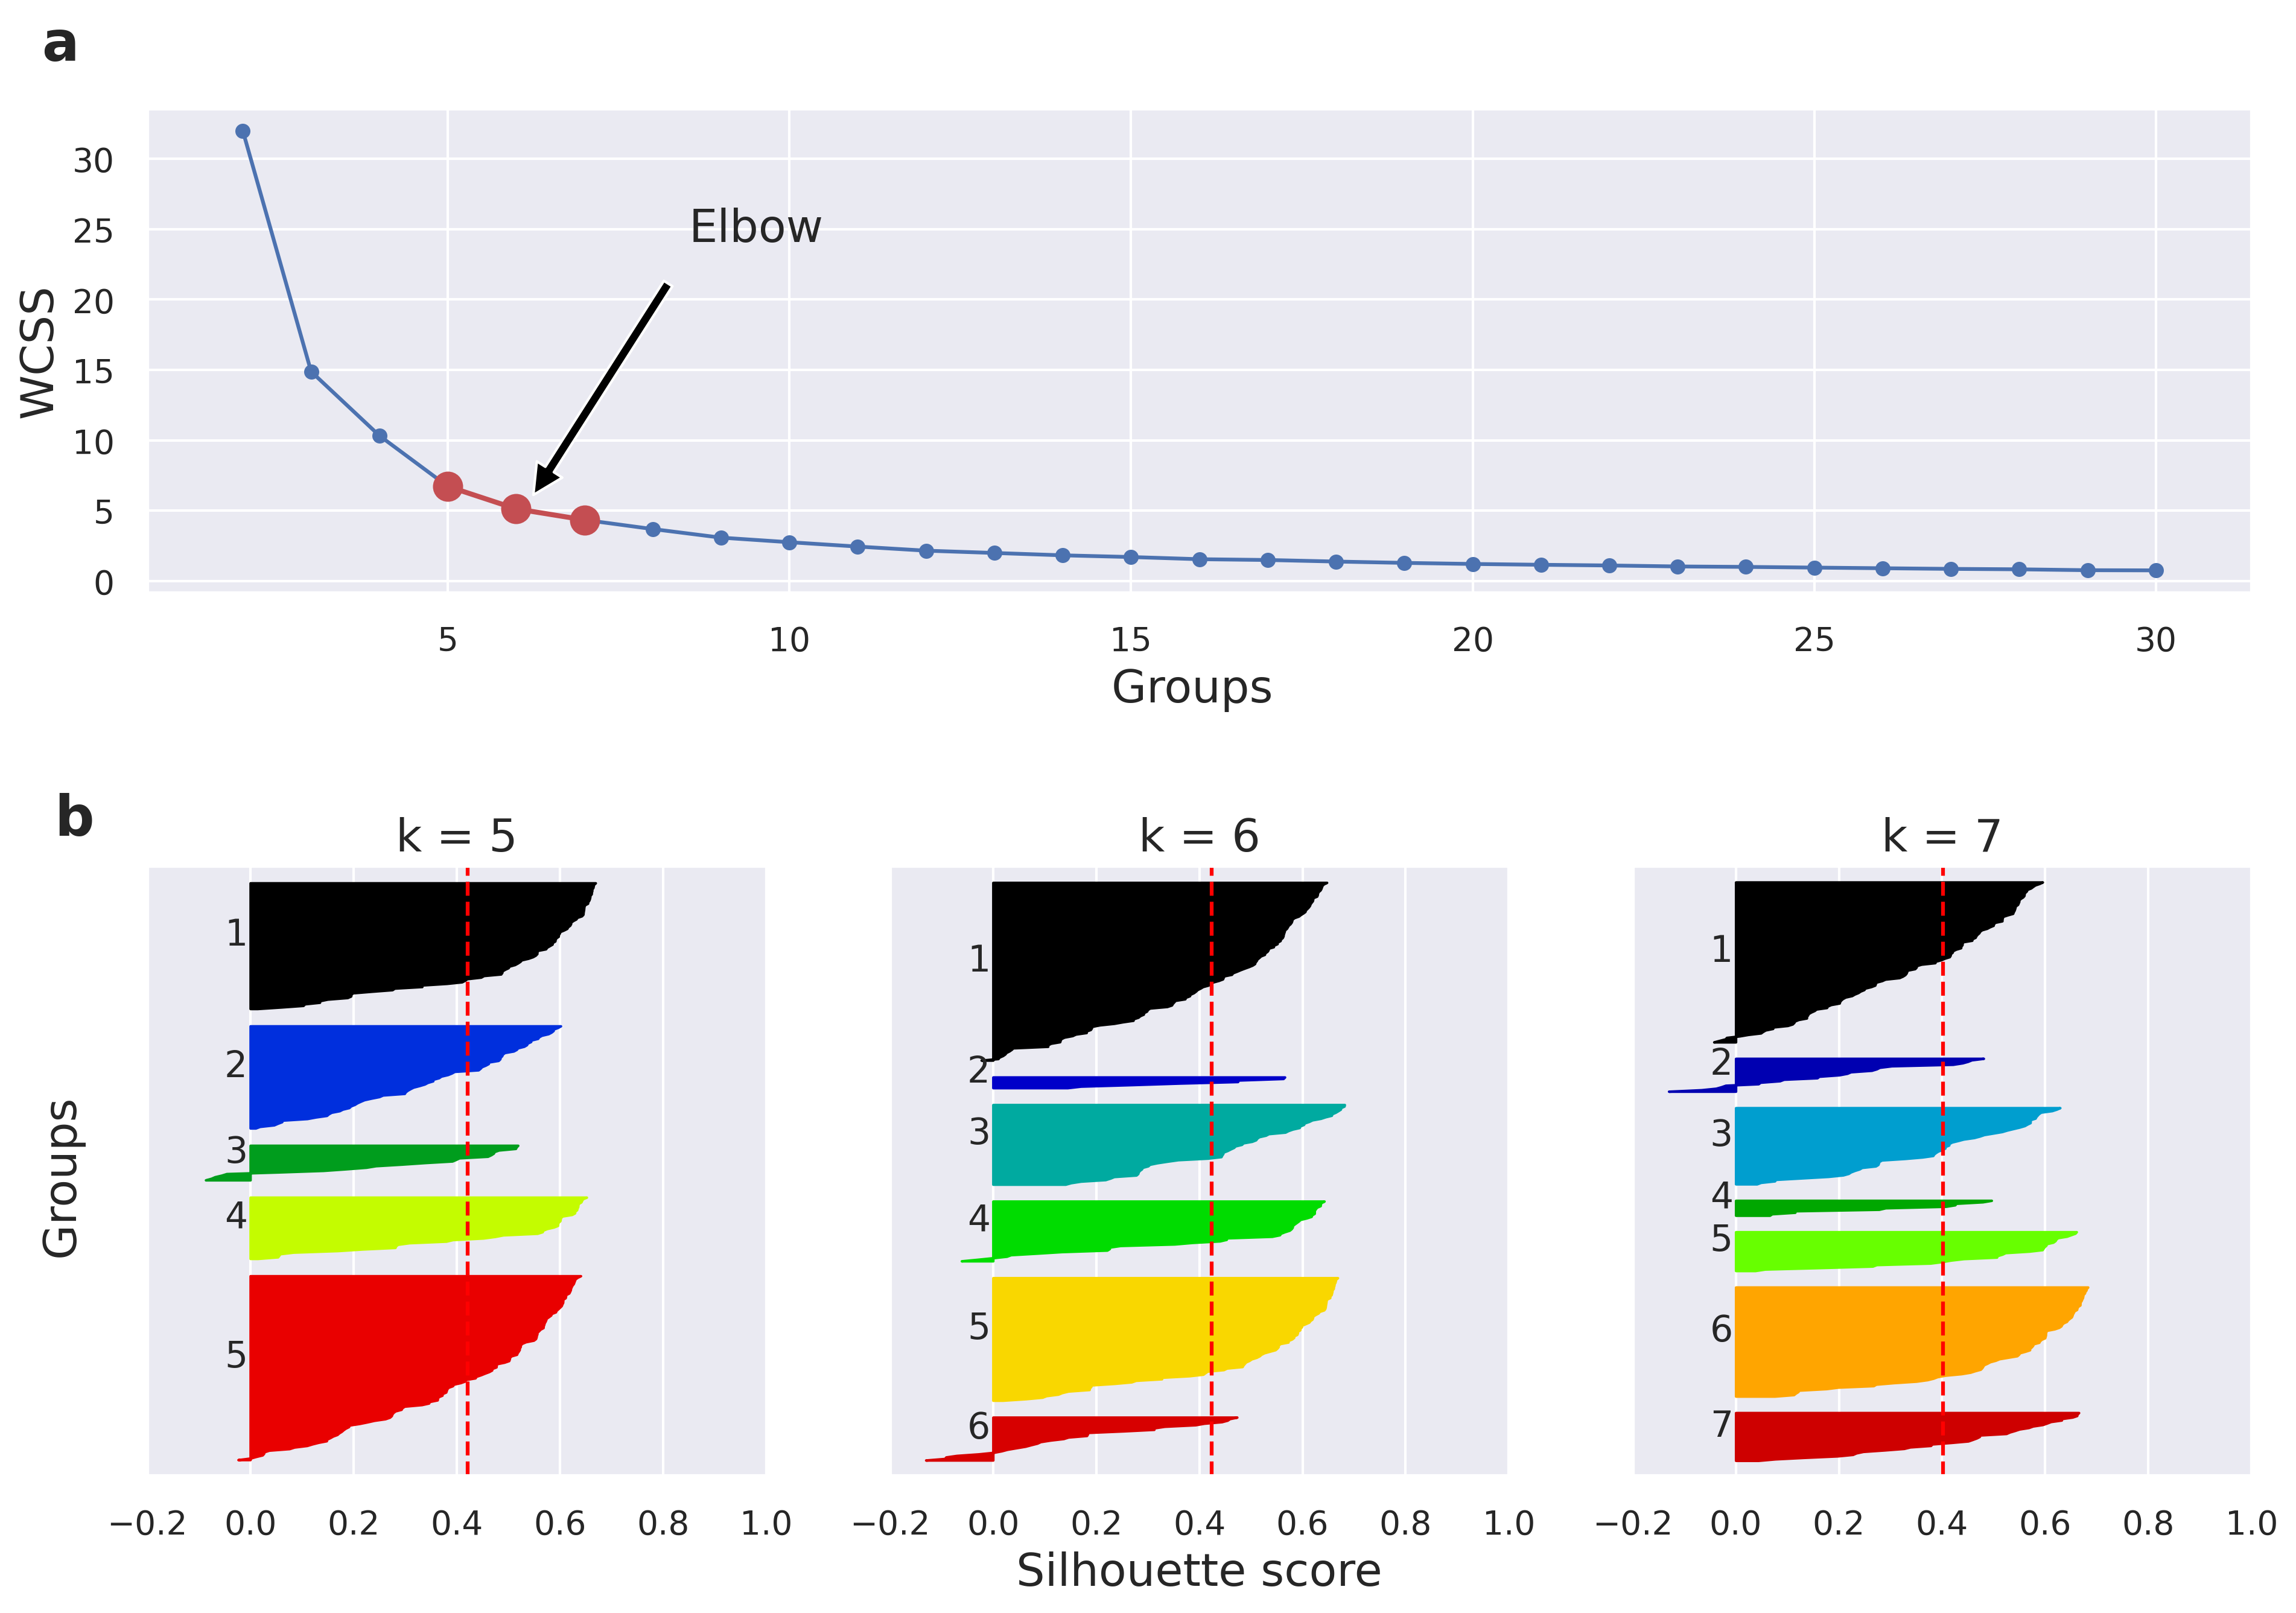

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [55]:
fontsize = 18
menork = 5 
maiork = 7
range_n = range(menork,maiork+1)
lim = 30
sns.set_theme()
sns.set(font_scale = 1.2)
silhouette_plot_(data_proces[features],range_n,lim)
data['group'] = model_top.predict(data_proces[features])


In [56]:
data.to_csv('/content/matopiba_emissions/output/matopiba_groups.csv')

# Análise dos grupos

In [57]:
data.group = data.group+1
lista = []
for g in data.group:
    lista.append(str("G"+str(g)))


data['group_name'] = lista
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


States           Municipalities    emi_2018  emi_agri_2018  emi_luc_2018  \
0     TO             AbreulÃ¢ndia   415469.12      127828.13        286357   
1     MA             AÃ§ailÃ¢ndia  2012738.16      701929.89       1033654   
2     MA             Afonso Cunha    77780.74        7322.15         59017   
3     MA  Ãgua Doce do MaranhÃ£o    28598.69        6986.73         15176   
4     TO           AguiarnÃ³polis   116760.47       20766.03         31678   

   emi_energy_2018  emi_waste_2018    pib_2018  population  \
0           530.51          753.48    52402.19        2564   
1        221796.36        55357.90  2602790.66      111757   
2         10089.06         1352.53    50235.77        6468   
3          3941.72         2494.25    86186.06       12488   
4         62457.73         1858.71   124903.42        6571   

   Agriculture and Livestock       LUC    Energy     Waste  group group_name  
0                   0.307672  0.689238  0.001277  0.001814      1         G1  
1                   0.348744  0.513556  0.110196  0.027504      1         G1  
2                   0.094138  0.758761  0.129712  0.017389      5         G5  
3                   0.244302  0.530654  0.137829  0.087216      1         G1  
4                   0.177852  0.271308  0.534922  0.015919      2         G2

### Perfil dos grupos (descrição)

#### Verificando diferenças significativas entre os grupos 

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import bartlett

l=range(1,max(data.grupo)+1)

count=0

grupos =[]

ps_all = []

parametric = True
for coluna in ["Agropecuária","MUT","Energia","Resíduos"]:
    count+=1
    print(coluna)
    k=0

    ps=[]
    met = []
    for i in l:
        k+=1
        for j in l[k:]:
            ''' Verificando se pode usar teste parametrico'''
            
            cat1 = data[data['grupo']==i]
            cat2 = data[data['grupo']==j]
            
            #Verificando o tamanho das amostras
            if min(len(cat1[coluna]),len(cat2[coluna]))>20:
                parametric = True
            else: parametric = False
            
            #verificando normalidade
            if parametric:
                _, p_1 = stats.normaltest(cat1[coluna])
                if p_1>=0.05:
                    print(str('Normal ' + str(i)+ ' p ='), p_1)
                    parametric = True

                else: parametric = False
            
            if parametric:
                _, p_2 = stats.normaltest(cat2[coluna])
                if p_2>=0.05:
                    parametric = True
                else: parametric = False
            
            #Verificando Homocedasticidade
            if parametric:
                _, p_v = bartlett(cat1[coluna], cat2[coluna])
                if p_v>=0.05:
                    parametric = False
                
                
            # teste de diferenças
            if parametric:
                _,p=ttest_ind(cat1[coluna], cat2[coluna])
                if p<0.01:
                    met.append('t**')
                elif 0.01<p<0.05:
                    met.append('t*')
                else:
                    met.append('t')
                ps.append(p)
            else:
                _,p=mannwhitneyu(cat1[coluna], cat2[coluna])
                ps.append(p)
                if p<0.01:
                    met.append('U**')
                elif 0.01<p<0.05:
                    met.append('U*')
                else:
                    met.append('U')
                # print(str('Fail ' + str(i)+'_'+str(j)+' p ='))

     
            if count==1:
                grupos.append(str(str(i)+'_'+str(j)))
                
            
            
    if count==1:
        ps_all.append(grupos)
            
    ps_all.append(ps)
    ps_all.append(met)



Agropecuária
Normal 1 p = 0.20690724036272934
Normal 1 p = 0.20690724036272934
Normal 1 p = 0.20690724036272934
Normal 1 p = 0.20690724036272934
Normal 4 p = 0.23394249204667575
Normal 4 p = 0.23394249204667575
Normal 5 p = 0.26147594321068274
MUT
Normal 1 p = 0.10812359586216852
Normal 1 p = 0.10812359586216852
Normal 1 p = 0.10812359586216852
Normal 1 p = 0.10812359586216852
Normal 5 p = 0.7455903166335365
Energia
Resíduos


In [ ]:
ps_all = np.array(ps_all).transpose()
dif = pd.DataFrame(ps_all,columns=['grupos',"Agropecuária",'Método',"MUT",'Método',"Energia",'Método',"Resíduos",'Método'])
dif.head(20)

grupos            Agropecuária Método                     MUT Método  \
0     1_2  4.4486549071262185e-05    U**  1.2042211933653515e-06    U**   
1     1_3  1.2187045642232775e-25    U**   9.597575133628476e-25    U**   
2     1_4  3.9554499608136606e-73    t**  2.1590634806295103e-21    U**   
3     1_5  1.0294108597528082e-29    U**   2.238017778652018e-30    U**   
4     1_6     0.10705489599813256      t   2.038015665782083e-43    t**   
5     2_3   3.109692593182338e-06    U**   3.109692593182338e-06    U**   
6     2_4  5.1107338223515976e-06    U**     0.47243096518540373      U   
7     2_5      0.1700667637623569      U   1.738611269331612e-06    U**   
8     2_6   0.0002807278382098792    U**   0.0002807278382098792    U**   
9     3_4  1.2739207333008779e-15    U**  1.3858760291311922e-16    U**   
10    3_5   7.954251343110861e-23    U**   7.954251343110861e-23    U**   
11    3_6   3.349590602362964e-11    U**   6.381269832679078e-05    U**   
12    4_5  1.7795010621614533e-73    t**  2.2656472350941046e-19    U**   
13    4_6   9.289238182617595e-13    U**  1.1620376169321032e-08    U**   
14    5_6   7.371977948998874e-20    t**   4.377407861911828e-49    t**   

                   Energia Método                Resíduos Método  
0   1.2042211933653515e-06    U**     0.08272396698219048      U  
1      0.40691689764497685      U     0.49597388986879276      U  
2      0.01472599711860026     U*   0.0006667543150694224    U**  
3      0.08382419938098168      U    0.031152663213252302     U*  
4    5.516325344568816e-16    U**   1.155373140024373e-09    U**  
5    3.109692593182338e-06    U**     0.09442737824069253      U  
6   5.1107338223515976e-06    U**     0.38572691460861613      U  
7    1.738611269331612e-06    U**     0.03591295060883048     U*  
8   1.0164421882806045e-05    U**     0.22472705749215438      U  
9      0.02284822761694854     U*   0.0034219945997669412    U**  
10     0.06958905311777874      U    0.046127212233748716     U*  
11   6.323268310457657e-14    U**   8.754989625356493e-09    U**  
12    0.001232310251865258    U**  4.7743512168376025e-06    U**  
13   9.829129345999696e-11    U**   5.399925261350775e-05    U**  
14  2.0948283291577924e-15    U**   6.051206830894866e-11    U**

In [ ]:
os.chdir('/content/drive/Shareddrives/MATOPIBA/analises/')
dif.to_csv('tests.csv')

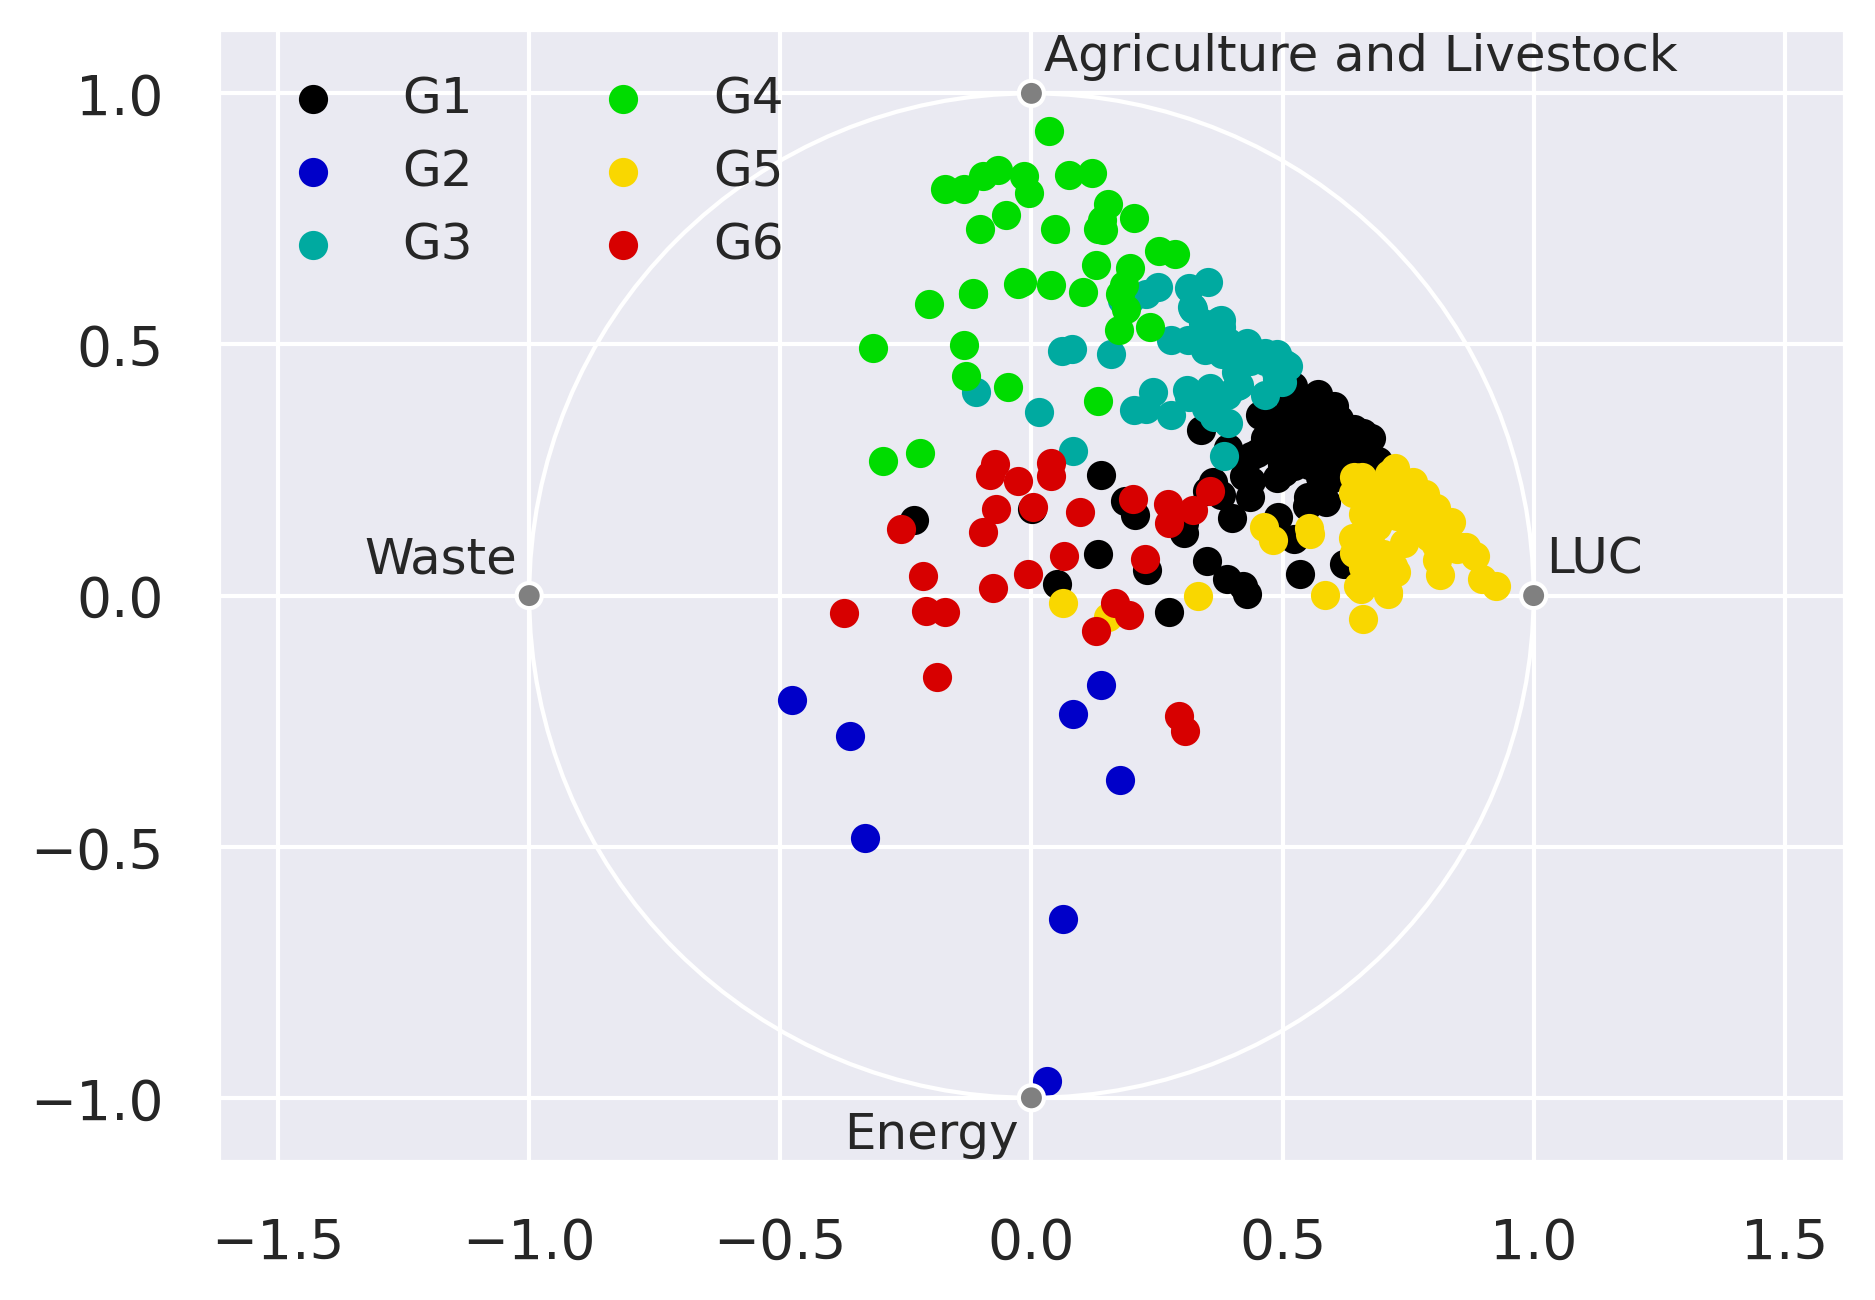

In [87]:
from pandas.plotting import radviz
fig = plt.figure(figsize = (7,5),dpi = 300)

radviz(data[["LUC","Agriculture and Livestock","Waste","Energy","group_name"]].sort_values(by='group_name'), 'group_name',color = color)
plt.legend(loc='upper left', ncol=2,fontsize=12)
plt.savefig("/content/matopiba_emissions/output/figure3.pdf", format="pdf", dpi=1000)

MATOPIBA
Agriculture and Livestock    35.670178
LUC                          54.518145
Energy                        7.057391
Waste                         2.754286
dtype: float64

Group: 1
Agriculture and Livestock    31.074964
LUC                          62.714663
Energy                        3.997788
Waste                         2.212584
dtype: float64

Group: 2
Agriculture and Livestock    15.154200
LUC                          16.867263
Energy                       60.536933
Waste                         7.441603
dtype: float64

Group: 3
Agriculture and Livestock    50.454921
LUC                          44.231051
Energy                        3.286759
Waste                         2.027270
dtype: float64

Group: 4
Agriculture and Livestock    73.479459
LUC                          17.322032
Energy                        5.933140
Waste                         3.265370
dtype: float64

Group: 5
Agriculture and Livestock    16.818369
LUC                          78.470569
Energy  

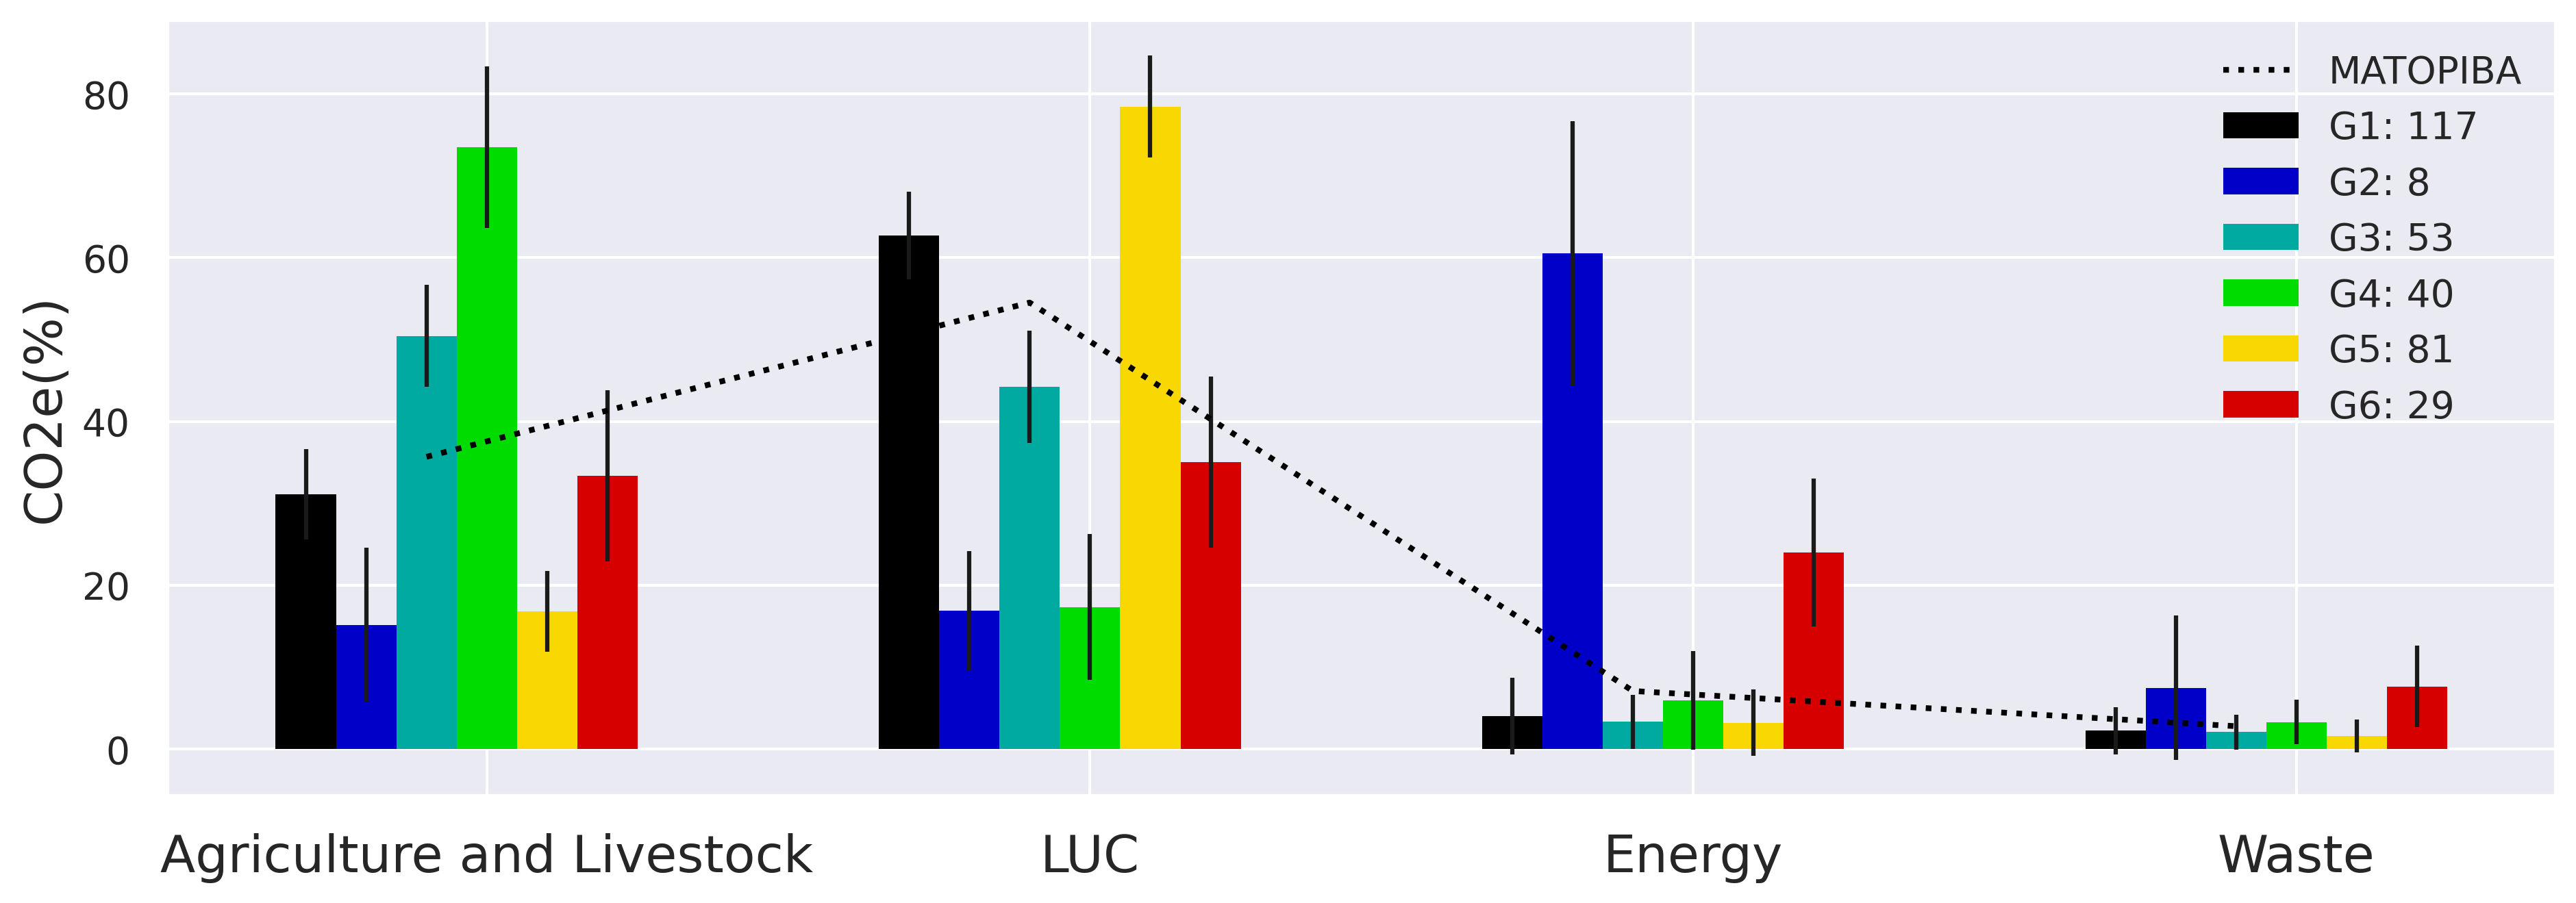

In [70]:
def bar_grupos(dados_sc,k):
  x = list(dados_sc.columns)[0:-1]
  
  fig = plt.figure(figsize = (15,5),dpi = 300)


  # plt.figure(figsize=(12, 5), dpi=300)
  j=0
  
  print("MATOPIBA")
  print(dados_sc.drop(['group'],axis=1).mean()*100)
  print()
    

  barWidth = 0.1
  r = np.arange(4)
  r = [x-3*barWidth for x in r]
  for i in range(1,k+1):
    dado_g = dados_sc.loc[dados_sc['group']==i]
    dado_g = dado_g.drop(['group'],axis=1)
    dado_g = dado_g
    color=(cm.nipy_spectral(float(i-1)*1.1 /k))
    r = [x + barWidth for x in r]
    plt.bar(r, dado_g.mean()*100, width = barWidth, color = color, 
            edgecolor = 'white', lw=0.0, alpha=1, yerr=dado_g.std()*100, label=str('G'+str(i)+': '+str(dado_g.shape[0])))
    
    print("Group: "+str(i))
    print(dado_g.mean()*100)
    print()
    j+=1

  #color=(cm.nipy_spectral(float(i+1) /k))
  dado_g = dados_sc.drop(['group'],axis=1)
  r = [x-3*barWidth for x in r]
  plt.grid(True)
  plt.plot(r,dado_g.mean()*100,':',label=('MATOPIBA'), 
        linewidth=2,color = 'black') # markersize=12*(dado_g.shape[0]/dados_sc.shape[0]))

  plt.xticks([r + barWidth for r in range(len(dado_g.mean()))],x,fontsize=fontsize)
  plt.ylabel('CO2e(%)',fontsize=fontsize)
  # plt.xlabel([ "Agropecuária","MUT","Energia","Resíduos"],fontsize=fontsize)
  plt.legend()
  '''
  # statistical annotation
  x1, x2 = 2, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
  y, h, col = tips['total_bill'].max() + 2, 2, 'k'
  plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
  plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
'''
    
    
bar_grupos(data[features_group],max(data[features_group].group))

plt.savefig("/content/matopiba_emissions/output/figure2b.pdf", format="pdf", dpi=1000)

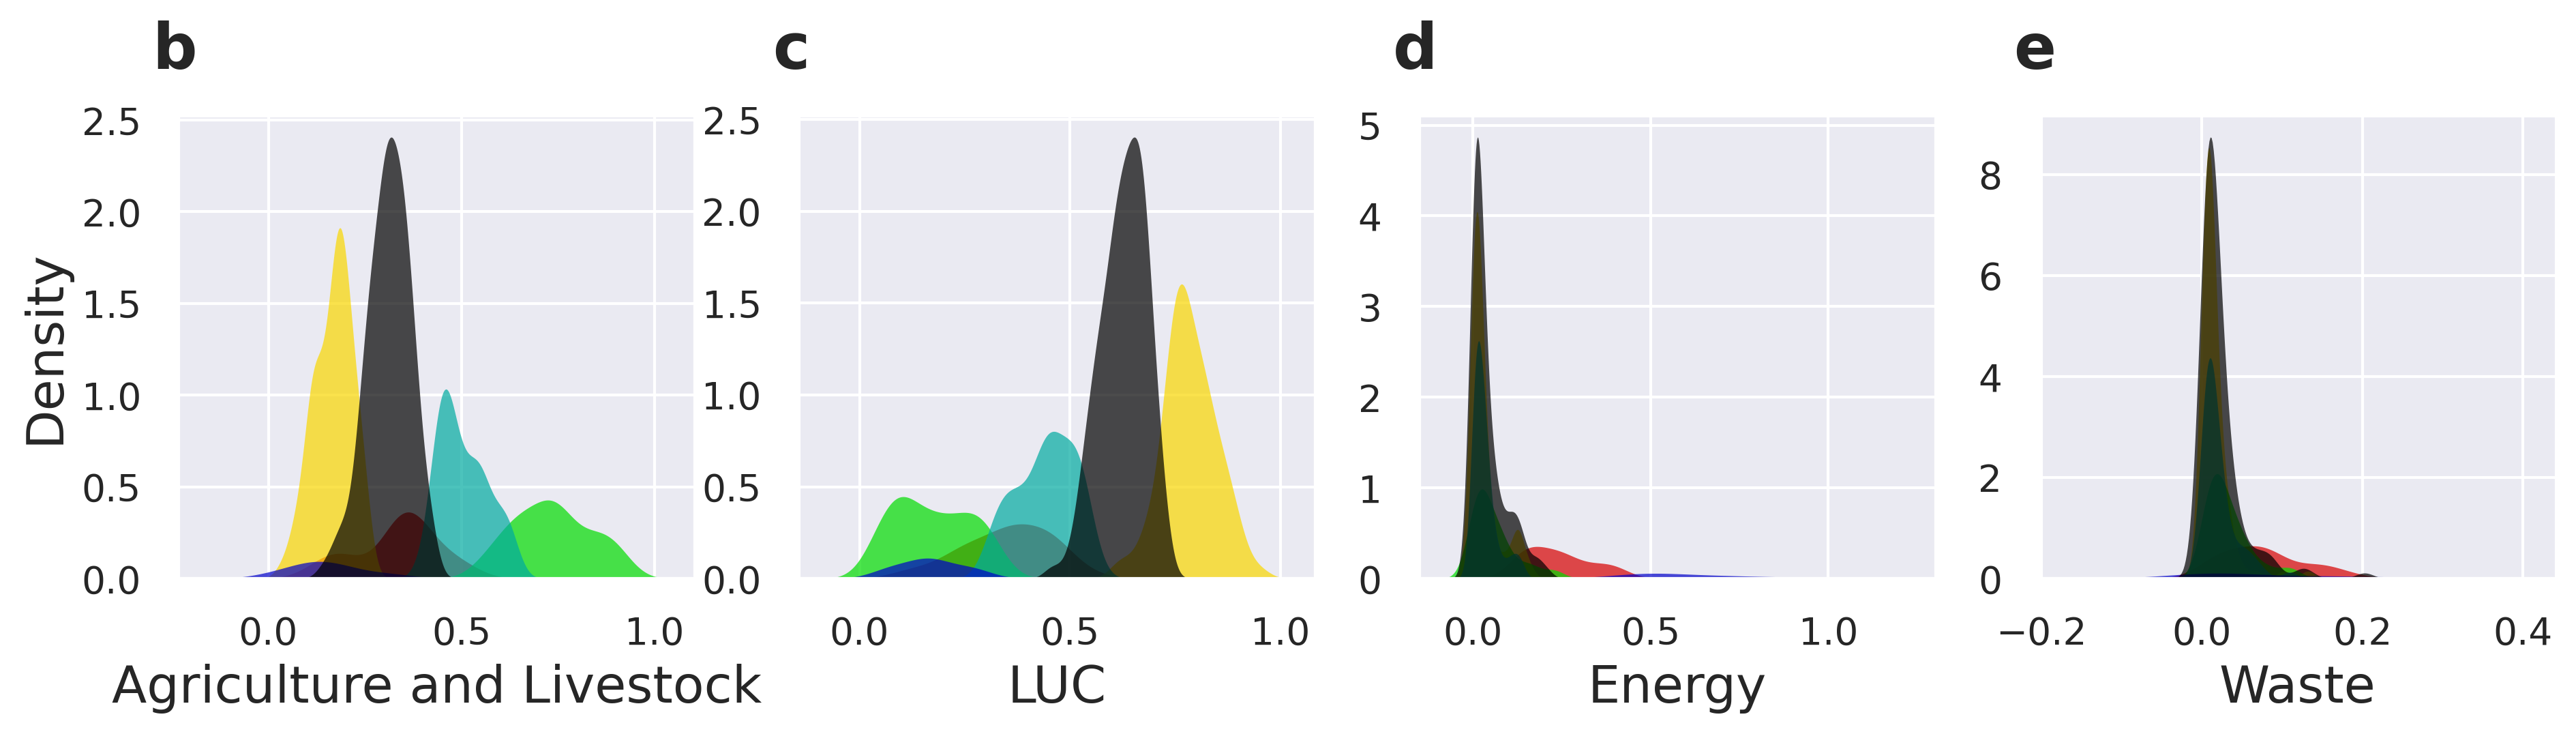

In [75]:
color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1/k))

fig = plt.figure(figsize = (15,3),dpi=300)

count=1
texto= ["b","c","d","e"]
for setor in features:

    plt.subplot(1,4,count)    
    ax=sns.kdeplot(data=data, x=setor, hue="group",palette=color ,fill=True,
   alpha=.7, linewidth=0,
)
    ax.text(-0.15/3, 1.1, texto[count-1], transform=ax.transAxes, 
            size=22, weight='bold')
    ax.set_xlabel(setor, fontsize=fontsize)
    if count ==1:
        ax.set_ylabel("Density", fontsize=fontsize)
        ax.legend_.set_title(None)
    else: 
        ax.set_ylabel(" ", fontsize=fontsize)
    count+=1
    ax.legend([],[], frameon=False)

plt.savefig("/content/matopiba_emissions/output/figure2a.pdf", format="pdf", dpi=1000)

### Complementando as análises 

#### Testando correlações 

Pearson assumptions: https://www.statisticssolutions.com/pearson-correlation-assumptions/#:~:text=The%20assumptions%20are%20as%20follows,each%20variable%20should%20be%20continuous.

In [58]:
grupos = []
estados = ['MA','TO', 'PI','BA']
for i in range(1,7):
    linha =[]
    # print()
    grupo = data[data['group']==i]
    # print("Grupo "+str(i)+':')
    linha.append('G' +str(i))
    for est in estados:
        
        # print(est +"=" + str(len(grupo[grupo['ESTADOS'] == est]) ))
        linha.append(len(grupo[grupo['States'] == est]))
    grupos.append(linha)
tab2 = pd.DataFrame(grupos,columns=['Group','MA','TO','PI','BA'])
tab2.head(7)

Group  MA  TO  PI  BA
0    G1  52  47  11   7
1    G2   3   4   0   1
2    G3  15  33   4   1
3    G4   5  18   4  13
4    G5  46  18  12   5
5    G6  13  12   1   3

In [ ]:
_, p1 = stats.normaltest(data['Agropecuária'])
_, p2 = stats.normaltest(data['MUT'])
print("Teste de normalidade: ",p1,p2)
data[["Agropecuária", 'MUT']].corr()
## -0.783561

Teste de normalidade:  1.8695449038763365e-08 8.360050436410542e-06


Agropecuária       MUT
Agropecuária      1.000000 -0.783561
MUT              -0.783561  1.000000

In [ ]:
#excluindo o grupo 2
_, p1 = stats.normaltest(data['Agropecuária'][data.grupo !=2])
_, p2 = stats.normaltest(data['MUT'][data.grupo !=2])
print("Teste de normalidade: ",p1,p2)
data[["Agropecuária", 'MUT']][data.grupo !=2].corr()
## -0.783561

Teste de normalidade:  2.6981531863338655e-08 2.5538535434967395e-05


Agropecuária       MUT
Agropecuária      1.000000 -0.882981
MUT              -0.882981  1.000000

In [ ]:
#excluindo o grupo 2 
_, p1 = stats.normaltest(data['Agropecuária'][data.grupo !=2][data.grupo !=6])
_, p2 = stats.normaltest(data['MUT'][data.grupo !=2][data.grupo !=6])
print("Teste de normalidade: ",p1,p2)
data[["Agropecuária", 'MUT']][data.grupo !=2][data.grupo !=6].corr()
## -0.783561

Teste de normalidade:  3.967594364228804e-07 6.673344850383256e-07


C:\Users\CepaTech\Documents\Miniconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Agropecuária       MUT
Agropecuária      1.000000 -0.954353
MUT              -0.954353  1.000000

In [ ]:
data[data.grupo==5].sort_values(by='emi_2018',ascending=False).tail(10)

ESTADOS                       CIDADES  emi_geral_2018  emi_agro_2018  \
297      MA  São Raimundo do Doca Bezerra        96507.46       19368.06   
169      MA                   Lima Campos        91854.22       17077.32   
236      TO     Porto Alegre do Tocantins        90923.62       18047.22   
175      PI                 Manoel Emídio        86024.63       16429.82   
2        MA                  Afonso Cunha        77780.74        7322.15   
199      MA                   Nova Iorque        75488.19       16916.46   
286      PI       São Gonçalo do Gurguéia        73279.67       14649.45   
330      MA                 Urbano Santos        61787.54        7088.74   
111      MA                 Duque Bacelar        57245.47       10914.27   
140      MA            Humberto de Campos        53128.37        6378.04   

     emi_mudterra_2018  emi_energia_2018  emi_residuos_2018   pib_2018  \
297              74979            573.94            1586.47   38455.46   
169              68340           3293.73            3143.18  171593.58   
236              70886            433.75            1556.65   31090.82   
175              66389           1538.62            1667.19   42088.65   
2                59017          10089.06            1352.53   50235.77   
199              56360            833.62            1378.11   38728.44   
286              56787            952.96             890.26   32269.84   
330              38858           7670.38            8170.42  191042.62   
111              41670           1858.10            2803.10   77042.93   
140              32767           8563.61            5419.73  161349.04   

     habitantes  Agropecuária       MUT   Energia  Resíduos  grupo grupo_name  \
297        5345      0.200690  0.776924  0.005947  0.016439      5         G5   
169       11866      0.185918  0.744005  0.035858  0.034219      5         G5   
236        3108      0.198488  0.779621  0.004770  0.017120      5         G5   
175        5347      0.190990  0.771744  0.017886  0.019380      5         G5   
2          6468      0.094138  0.758761  0.129712  0.017389      5         G5   
199        4682      0.224094  0.746607  0.011043  0.018256      5         G5   
286        3024      0.199912  0.774935  0.013004  0.012149      5         G5   
330       32775      0.114728  0.628897  0.124141  0.132234      5         G5   
111       11296      0.190657  0.727918  0.032458  0.048966      5         G5   
140       28497      0.120050  0.616751  0.161187  0.102012      5         G5   

     Emissões/hab  Emissões/PIB  
297     18.055652      2.509591  
169      7.740959      0.535301  
236     29.254704      2.924452  
175     16.088392      2.043891  
2       12.025470      1.548314  
199     16.123065      1.949167  
286     24.232695      2.270841  
330      1.885203      0.323423  
111      5.067765      0.743033  
140      1.864350      0.329276